In [1]:
"""
allen-cahn_equation.ipynb

Created on Wed Apr 5 2023

@author: Lukas

This notebook contains all experiments on the Allen-Cahn Equation from this 
(https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/allen.cahn.html) DeepXDE demo.
"""

'\nallen-cahn_equation.ipynb\n\nCreated on Wed Apr 5 2023\n\n@author: Lukas\n\nThis notebook contains all experiments on the Allen-Cahn Equation from this \n(https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/allen.cahn.html) DeepXDE demo.\n'

In this notebook, [...]

In [2]:
# install DeepXDE

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.0 MB/s eta 0:00:00


In [3]:
# import packages

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from deepxde.backend import tf

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [29]:
# set up the problem

def gen_testdata():
    data = loadmat("/content/Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    dt = dx = 0.01
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
d = 0.001

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - d * dy_xx - 5 * (y - y**3)

# define the boundary and initial conditions

def func(x):
    return (x[:, 0:1])**2 * np.cos(np.pi * x[:, 0:1])

bc = dde.icbc.DirichletBC(geomtime, lambda x: -1, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: (x[:, 0:1])**2 * np.cos(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Hard restraints on initial + boundary conditions   MIGHT WANT TO TEST THE EFFECT OF THIS ON EXTRAPOLATION BEHVAVIOR
def output_transform(x, y):
   return x[:, 0:1]**2 * tf.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=8000, num_boundary=400, num_initial=800)

In [31]:
# set up the model

net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")
# net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.103380 s

'compile' took 1.161540 s



In [8]:
# train the model

losshistory, train_state  = model.train(epochs=30000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.52e+00, 1.37e+00, 2.15e-01]    [1.52e+00, 1.37e+00, 2.15e-01]    []  
1000      [2.29e-02, 2.18e-02, 5.49e-02]    [2.29e-02, 2.18e-02, 5.49e-02]    []  
2000      [6.90e-03, 2.11e-03, 9.03e-03]    [6.90e-03, 2.11e-03, 9.03e-03]    []  
3000      [1.33e-03, 4.03e-04, 2.20e-03]    [1.33e-03, 4.03e-04, 2.20e-03]    []  
4000      [5.24e-04, 2.31e-04, 1.79e-03]    [5.24e-04, 2.31e-04, 1.79e-03]    []  
5000      [2.99e-04, 2.43e-04, 1.54e-03]    [2.99e-04, 2.43e-04, 1.54e-03]    []  
6000      [2.42e-04, 2.37e-04, 1.47e-03]    [2.42e-04, 2.37e-04, 1.47e-03]    []  
7000      [3.35e-04, 2.66e-04, 1.33e-03]    [3.35e-04, 2.66e-04, 1.33e-03]    []  
8000      [1.97e-04, 2.41e-04, 1.31e-03]    [1.97e-04, 2.41e-04, 1.31e-03]    []  
9000      [3.20e-04, 2.16e-04, 1.32e-03]    [3.20e-04, 2.16e-04, 1.32e-03]    []  
10000     [1.68e-04, 2.49e-04, 1.18

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


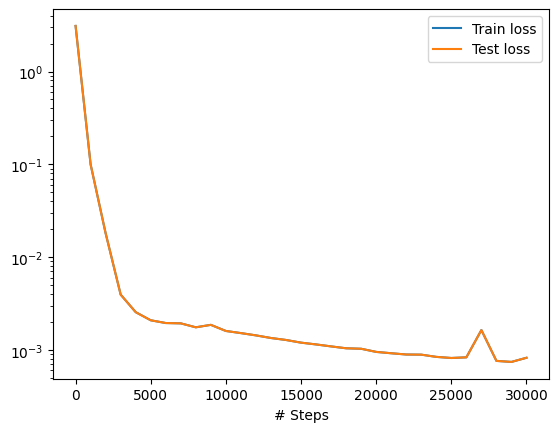

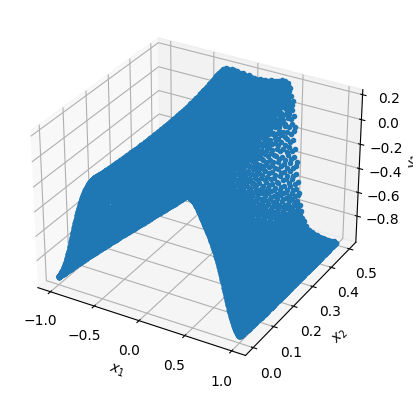

In [9]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [11]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.2703169
L2 relative error: 0.3903796917415757


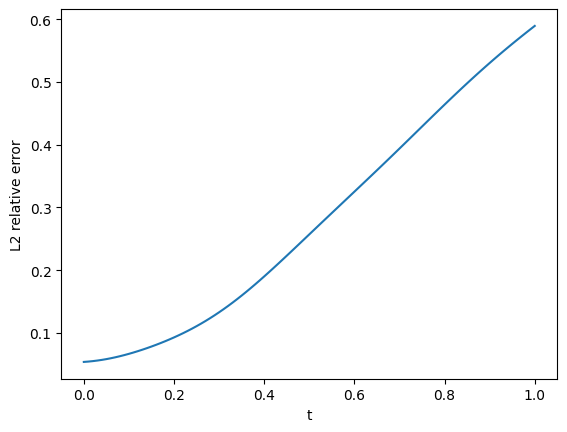

In [12]:
# compute the L2 relative error between the true solution and the predicted solution

rel_l2_errors = []

for i in range(0, 20200, 201):
    y_pred = model.predict(X[i:i+201])
    y_sol = y_true[i:i+201]

    # collect the relative L2 errors in a list
    rel_l2_errors.append(dde.metrics.l2_relative_error(y_sol, y_pred))


# plot the relative L2 errors

x = np.linspace(0, 1, 101)
plt.plot(x, rel_l2_errors)
plt.xlabel("t")
plt.ylabel("L2 relative error")
plt.show()

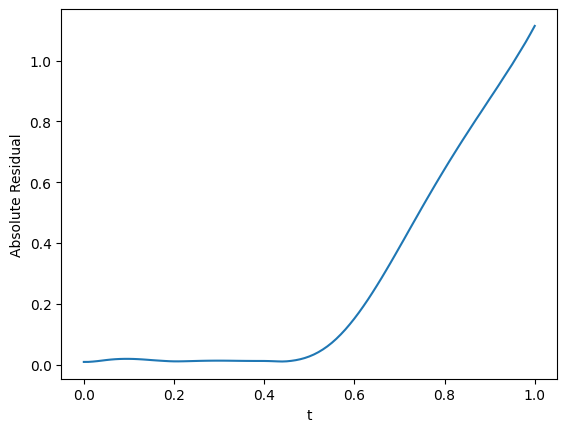

In [13]:
# compute the absolute residuals

absolute_residual = []

for i in range(0, 20200, 201):
    absolute_residual.append(np.mean(np.absolute(f)[i:i+201]))


# plot the relative absolute residuals

x = np.linspace(0, 1, 101)
plt.plot(x, absolute_residual)
plt.xlabel("t")
plt.ylabel("Absolute Residual")
plt.show()

In [32]:
zero_predictions = [] # actually evaluations of the model at t = 0.1 ...
half_predictions = []
one_predictions = []

In [33]:
for i in range(5):
    model.train(iterations=6000)

    x = geom.uniform_points(201, True)
    t = np.full(201, 0.1)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    zero_predictions.append(y)

    x = geom.uniform_points(201, True)
    t = np.full(201, 0.5)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    half_predictions.append(y)

    x = geom.uniform_points(201, True)
    t = np.full(201, 1.0)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    one_predictions.append(y)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.40e-01, 1.16e+00, 1.68e-01]    [6.40e-01, 1.16e+00, 1.68e-01]    []  
1000      [2.66e-02, 1.12e-02, 5.07e-02]    [2.66e-02, 1.12e-02, 5.07e-02]    []  
2000      [2.11e-02, 9.25e-03, 4.03e-02]    [2.11e-02, 9.25e-03, 4.03e-02]    []  
3000      [7.00e-03, 7.62e-04, 8.58e-03]    [7.00e-03, 7.62e-04, 8.58e-03]    []  
4000      [1.82e-03, 1.17e-04, 3.06e-03]    [1.82e-03, 1.17e-04, 3.06e-03]    []  
5000      [3.46e-03, 5.72e-05, 2.33e-03]    [3.46e-03, 5.72e-05, 2.33e-03]    []  
6000      [1.56e-03, 6.93e-05, 1.70e-03]    [1.56e-03, 6.93e-05, 1.70e-03]    []  

Best model at step 6000:
  train loss: 3.33e-03
  test loss: 3.33e-03
  test metric: []

'train' took 20.246864 s

Training model...

Step      Train loss                        Test loss                         Test metric
6000      [1.56e-03, 6.93e-05, 1.70e-03]    [1.56e-03, 6.93

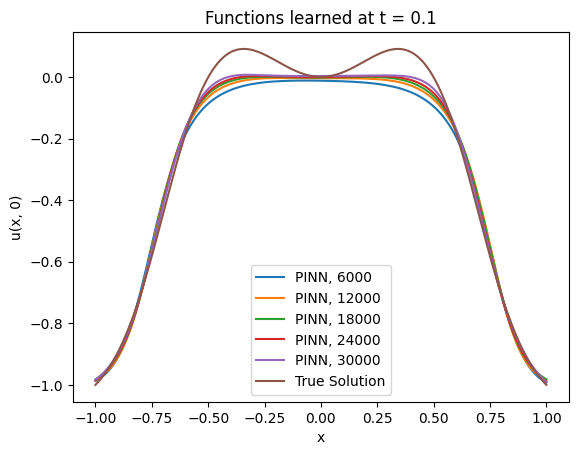

In [34]:
# plot the solution and compare it to the true solution

for i in range(len(zero_predictions)):
    plt.plot(np.linspace(-1, 1, 201), zero_predictions[i][:, 0], label="PINN, " + str((i+1) * 6000))

plt.plot(np.linspace(-1, 1, 201), y_true[2010:2211], label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0.1")
plt.xlabel("x")
plt.ylabel("u(x, 0)")
plt.show()

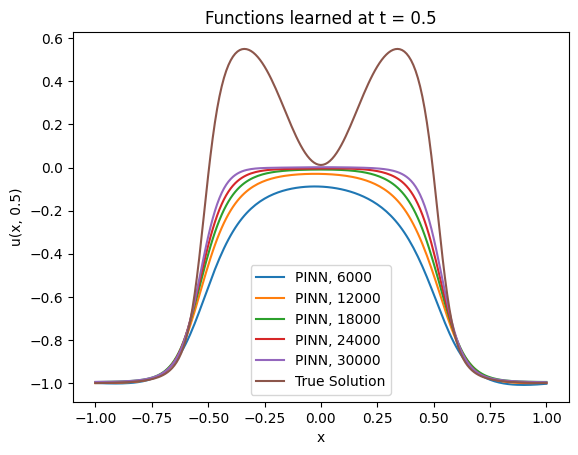

In [35]:
# plot the solution and compare it to the true solution

for i in range(len(zero_predictions)):
    plt.plot(np.linspace(-1, 1, 201), half_predictions[i][:, 0], label="PINN, " + str((i+1) * 6000))

plt.plot(np.linspace(-1, 1, 201), y_true[10050:10251], label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x, 0.5)")
plt.show()

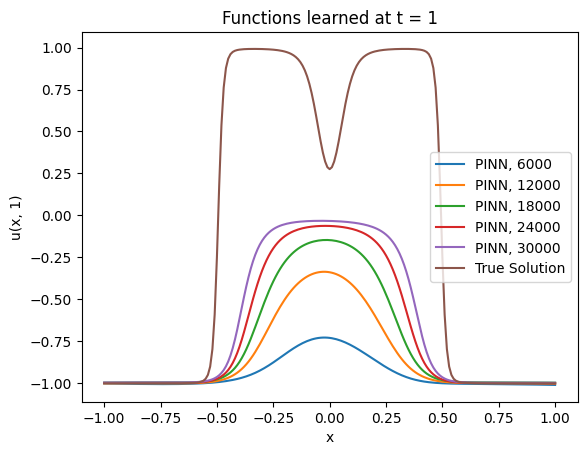

In [36]:
# plot the solution and compare it to the true solution

for i in range(len(zero_predictions)):
    plt.plot(np.linspace(-1, 1, 201), one_predictions[i][:, 0], label="PINN, " + str((i+1) * 6000))

plt.plot(np.linspace(-1, 1, 201), y_true[20100:20301], label="True Solution")
plt.legend()
plt.title("Functions learned at t = 1")
plt.xlabel("x")
plt.ylabel("u(x, 1)")
plt.show()

In [ ]:
mean_residual_inter = []
mean_residual_extra = []

l2_error_inter = []
l2_error_extra = []

In [ ]:
# record mean residuals and l2-residuals over training epochs for t in [0, 1]

for i in range(30):
    model.train(iterations=1000)

    y_pred = model.predict(X)
    f = model.predict(X, operator=pde)

    mean_residual_inter.append(np.mean(np.absolute(f)[:10050]))
    l2_error_inter.append(dde.metrics.l2_relative_error(y_true[:10050], y_pred[:10050]))

    mean_residual_extra.append(np.mean(np.absolute(f)[10050:]))
    l2_error_extra.append(dde.metrics.l2_relative_error(y_true[10050:], y_pred[10050:]))

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [7.37e-01]    [7.37e-01]    []  
1000      [9.23e-03]    [9.23e-03]    []  

Best model at step 1000:
  train loss: 9.23e-03
  test loss: 9.23e-03
  test metric: []

'train' took 14.863271 s

Training model...

Step      Train loss    Test loss     Test metric
1000      [9.23e-03]    [9.23e-03]    []  
2000      [3.45e-03]    [3.45e-03]    []  

Best model at step 2000:
  train loss: 3.45e-03
  test loss: 3.45e-03
  test metric: []

'train' took 8.081609 s

Training model...

Step      Train loss    Test loss     Test metric
2000      [3.45e-03]    [3.45e-03]    []  
3000      [1.20e-03]    [1.20e-03]    []  

Best model at step 3000:
  train loss: 1.20e-03
  test loss: 1.20e-03
  test metric: []

'train' took 8.201658 s

Training model...

Step      Train loss    Test loss     Test metric
3000      [1.20e-03]    [1.20e-03]    []  
4000      [6.14e-04]    [6.14e-04]    []  

Best mo

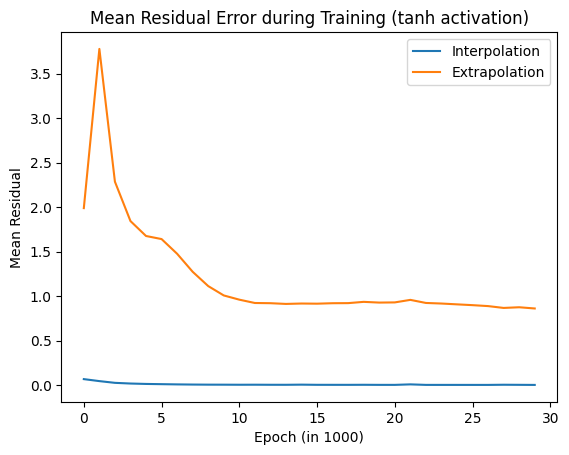

In [ ]:
# plot the mean residual in interpolation and extrapolation against the training epochs

plt.plot([*range(30)], mean_residual_inter, label="Interpolation")
plt.plot([*range(30)], mean_residual_extra, label="Extrapolation")

plt.legend()
plt.title("Mean Residual Error during Training (tanh activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("Mean Residual")
plt.show()

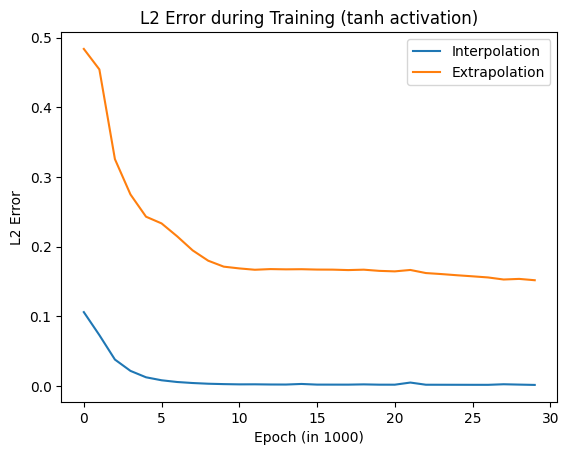

In [ ]:
# plot the mean residual in interpolation and extrapolation against the training epochs

plt.plot([*range(30)], l2_error_inter, label="Interpolation")
plt.plot([*range(30)], l2_error_extra, label="Extrapolation")

plt.legend()
plt.title("L2 Error during Training (tanh activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("L2 Error")
plt.show()